# A comparison of how radical applys its correction
1. Open a radical data file (must be saved as matlab v7.3 environment->preferences->General->MAT-files->V7.3)
2. plot calibrated data
3. retrieve uncorrected DUT
4. retrieve solution vector
5. plot non reciprocal corrected data
6. plot reciprocal corrected data
7. compare with 2

In [1]:
# import libraries
from pyMeasure import *
import os
import h5py
import numpy as np

Importing Code.Utils.Names
Importing Code.DataHandlers.NISTModels
Importing Code.DataHandlers.GeneralModels
Importing Code.DataHandlers.TouchstoneModels
Importing Code.DataHandlers.XMLModels
Importing Code.DataHandlers.Translations
Importing Code.DataHandlers.StatistiCALModels
Importing Code.DataHandlers.MUFModels
Importing Code.Analysis.SParameter
Importing Code.InstrumentControl.Instruments
Importing Code.InstrumentControl.Experiments


In [2]:
# set the directory paths and file path
JUPYTER_DIRECTORY=r'C:\Users\sandersa\PyCharm Projects\Jupyter-Notebooks'
TEST_DIRECTORY=os.path.join(JUPYTER_DIRECTORY,"Radical_Correction_Files")
RADICAL_DATA_PATH=os.path.join(TEST_DIRECTORY,"Example_HD5.mat")

In [3]:
# open the radical file
radical_data_file=h5py.File(RADICAL_DATA_PATH,'r')

In [4]:
# Explore the data in the radical data file
print("Level One: {0}".format(radical_data_file.keys()))
print("Level Two: {0}".format(radical_data_file["RadiCalData"].keys()))
def print_hd5_keys(hd5_group):
    """Prints hd5 keys and passes if there are none"""
    try:
        print hd5_group
    except: pass
radical_data_file["RadiCalData"].visit(print_hd5_keys)
# for group in radical_data_file:
#     print group

Level One: [u'#refs#', u'RadiCalData']
Level Two: [u'C', u'Count', u'Dir', u'Dut', u'DutDir', u'FigureHandle', u'Opts', u'Rdc', u'Ref', u'RefDir', u'Rs2C', u'RsL', u'StatistiCalData', u'Test', u'TestDir']
C
Count
Dir
Dir/Data
Dir/RadiCal
Dir/SpecSheetName
Dir/SpecSheetPath
Dir/StatistiCAL
Dir/SwitchTerms
Dir/SwitchTerms/Name
Dir/SwitchTerms/Path
Dir/SwitchTerms/RFName
Dir/SwitchTerms/RFPath
Dut
Dut/Calibrated
Dut/CorrectionOption
Dut/RawStandards
Dut/RecStds
Dut/Standards
Dut/StdsNames
DutDir
FigureHandle
Opts
Rdc
Ref
Ref/Calibrated
Ref/Guess
Ref/Guess/CIR
Ref/Guess/EpsEff
Ref/Guess/Error
Ref/Guess/PropConst
Ref/Guess/RsModel
Ref/Guess/S1
Ref/Guess/S1Zc
Ref/Guess/S2
Ref/Guess/S2Zc
Ref/Guess/T1
Ref/Guess/T2
Ref/Guess/Z
Ref/Lengths
Ref/MapFunc
Ref/Name
Ref/RFSwitchTerms
Ref/RawStandards
Ref/RecStds
Ref/SeriesR
Ref/SpecSheet
Ref/Standards
Ref/StdsNames
Ref/SwitchTerms
Ref/TRL
Ref/TRL/C
Ref/TRL/Eps
Ref/TRL/ErrEps
Ref/TRL/Models
Ref/TRL/Models/Rs
Ref/TRL/Models/RsCir
Ref/TRL/Models/RsErr
Re

In [5]:
# The corrected S parameters for short
corrected_short=np.array(radical_data_file["RadiCalData/StatistiCalData/S"])

In [6]:
# The Frequency list
frequency_list=np.array(radical_data_file["RadiCalData/StatistiCalData/F"])[0].tolist()


In [7]:
# putting them into [f,S11,S21,S12,S22] format
sparameters=[]
sparameters_flipped=[]
for index,item in enumerate(frequency_list):
    [S11,S21,S12,S22]=[complex(corrected_short[0][index][0],corrected_short[0][index][1]),
                       complex(corrected_short[1][index][0],corrected_short[1][index][1]),
                       complex(corrected_short[2][index][0],corrected_short[2][index][1]),
                       complex(corrected_short[3][index][0],corrected_short[3][index][1])]
    new_row=[item,S11,S21,S12,S22]
    sparameters.append(new_row)
    sparameters_flipped.append([item,S11,S12,S21,S22])

def radical_to_s2p(radical_data_set,frequency_list,**options):
    """Takes a radical data set that is of the form <HDF5 dataset "S1": shape (4, 512), type "|V16"> and outputs
    an S2PV1 python model. Requires frequency_list=np.array(radical_data_file["RadiCalData/StatistiCalData/F"])[0].tolist()
    to be passed"""
    defaults={"frequency_selector":0,"frequency_column_name":"Frequency"}
    s2p_options={}
    for key,value in defaults.iteritems():
        s2p_options[key]=value
    for key,value in options.iteritems():
        s2p_options[key]=value
    input_data=np.array(radical_data_set)
    for index,item in enumerate(frequency_list):
        [S11,S21,S12,S22]=[complex(input_data[0][index][0],input_data[0][index][1]),
                           complex(input_data[1][index][0],input_data[1][index][1]),
                           complex(input_data[2][index][0],input_data[2][index][1]),
                           complex(input_data[3][index][0],input_data[3][index][1])]
        new_row=[item,S11,S21,S12,S22]
        sparameters.append(new_row)
    new_s2p=S2PV1(None,sparameter_complex=sparameters,**s2p_options)
    return new_s2p

In [8]:
# make a s2p file out of them
new_s2p=S2PV1(None,sparameter_complex=sparameters)
new_s2p_flipped=S2PV1(None,sparameter_complex=sparameters_flipped)

<IPython.core.display.Javascript object>


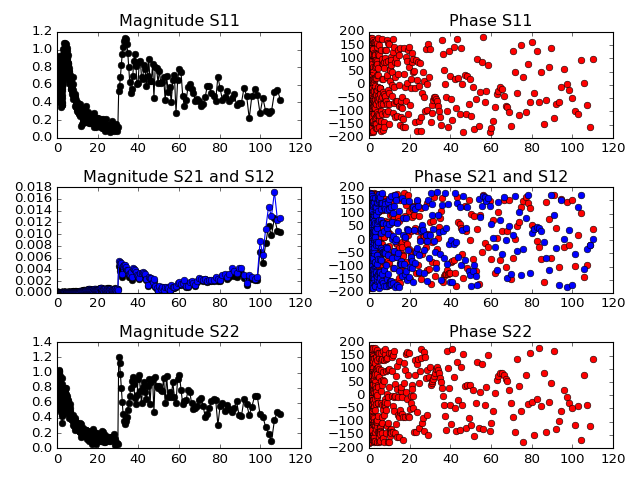

In [27]:
%matplotlib notebook
# Now show them
new_s2p.show()

<IPython.core.display.Javascript object>


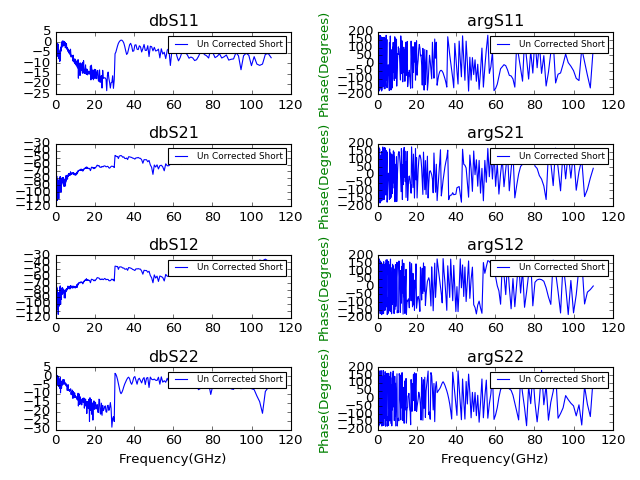

In [26]:
compare_s2p_plots([new_s2p],labels=["Un Corrected Short"],format="db")

<IPython.core.display.Javascript object>


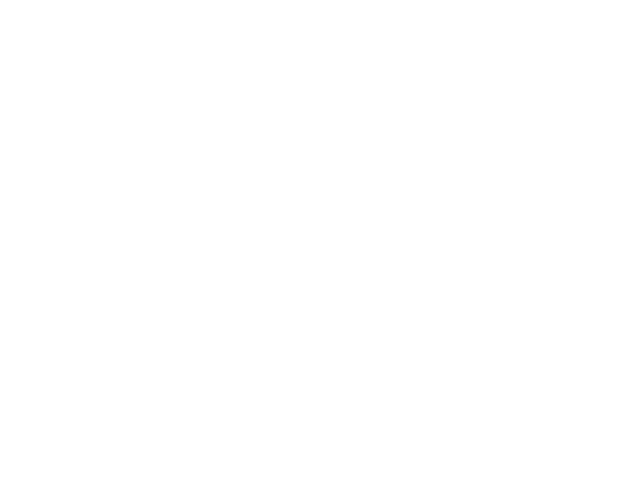

In [11]:
compare_s2p_plots([new_s2p,new_s2p_flipped],labels=["Un Corrected Short","Transmission Flipped"],format="MA")

In [12]:
# Now we need to apply a reciprocal correction to compare
# This is a standard in RadiCalData.Ref.TRL.Models.S1
radical_data_file["RadiCalData/Ref/TRL/Models/S1"]

<HDF5 dataset "S1": shape (4, 512), type "|V16">

In [13]:
def radical_to_s2p(radical_data_set,frequency_list,**options):
    """Takes a radical data set that is of the form <HDF5 dataset "S1": shape (4, 512), type "|V16"> and outputs
    an S2PV1 python model. Requires frequency_list=np.array(radical_data_file["RadiCalData/StatistiCalData/F"])[0].tolist()
    to be passed"""
    defaults={"frequency_selector":0,"frequency_column_name":"Frequency"}
    s2p_options={}
    for key,value in defaults.iteritems():
        s2p_options[key]=value
    for key,value in options.iteritems():
        s2p_options[key]=value
    input_data=np.array(radical_data_set)
    sparameters=[]
    for index,item in enumerate(frequency_list):
        [S11,S21,S12,S22]=[complex(input_data[0][index][0],input_data[0][index][1]),
                           complex(input_data[1][index][0],input_data[1][index][1]),
                           complex(input_data[2][index][0],input_data[2][index][1]),
                           complex(input_data[3][index][0],input_data[3][index][1])]
        new_row=[item,S11,S21,S12,S22]
        sparameters.append(new_row)
    new_s2p=S2PV1(None,sparameter_complex=sparameters,**s2p_options)
    return new_s2p

In [14]:
S1=radical_to_s2p(radical_data_file["RadiCalData/Ref/TRL/Models/S1"],frequency_list)
S=radical_to_s2p(radical_data_file["RadiCalData/StatistiCalData/S"],frequency_list)

<IPython.core.display.Javascript object>


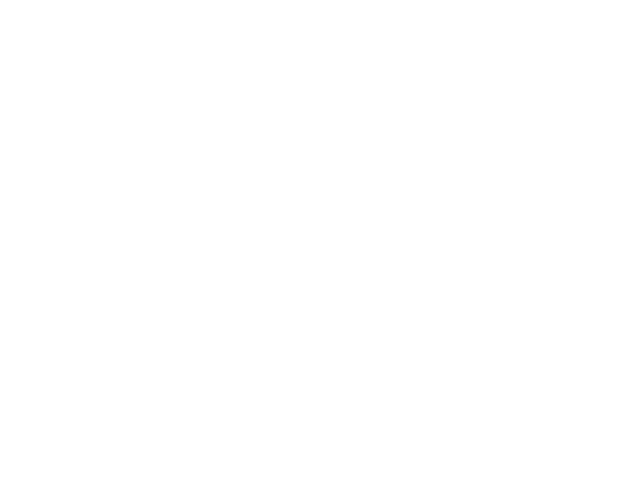

In [15]:
compare_s2p_plots([S1,S],labels=["Corr","Un Corr"],format="DB")

<IPython.core.display.Javascript object>


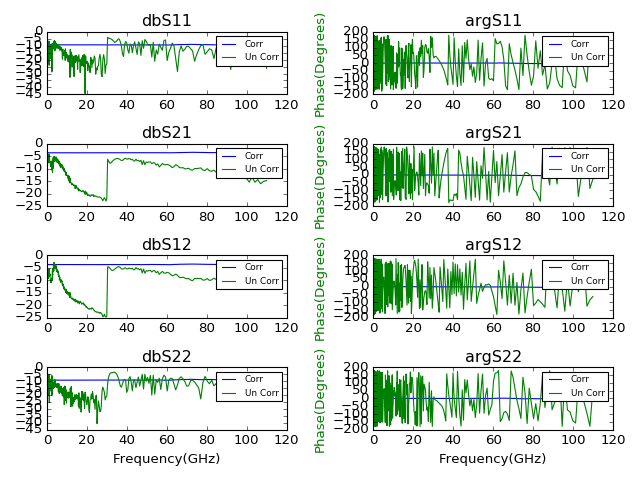

In [25]:
Rs=radical_to_s2p(radical_data_file["RadiCalData/StatistiCalData/Rs"],frequency_list)
Rs_Corrected=radical_to_s2p(radical_data_file["RadiCalData/Ref/TRL/Models/Rs"],frequency_list)
compare_s2p_plots([Rs_Corrected,Rs],labels=["Corr","Un Corr"],format="DB")

<IPython.core.display.Javascript object>


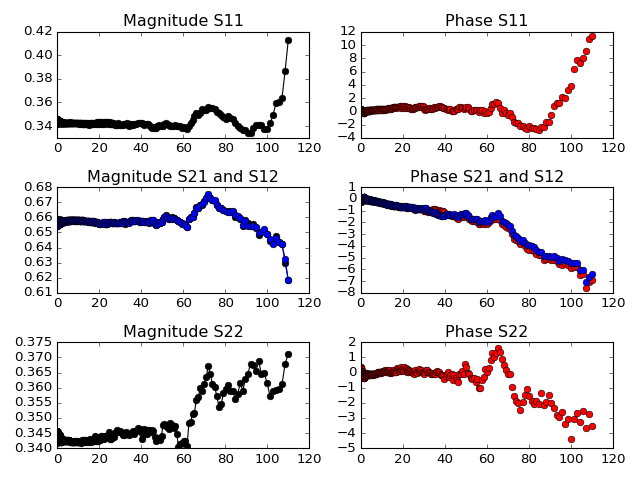

In [24]:
Rs_Corrected.show()

In [18]:
data=np.array(radical_data_file["RadiCalData/Dut/Calibrated"])

In [19]:
radical_data_file[radical_data_file[np.array(radical_data_file["RadiCalData/Dut/Calibrated"])[0][0]][0][0]]

<HDF5 dataset "uu": shape (4, 512), type "|V16">

In [20]:
DUT_1=radical_to_s2p(radical_data_file[radical_data_file[np.array(radical_data_file["RadiCalData/Dut/Calibrated"])[0][0]][0][0]],
                     frequency_list)

<IPython.core.display.Javascript object>


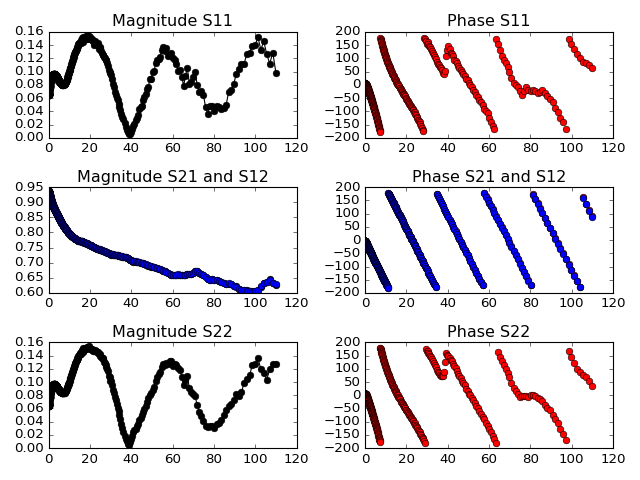

In [23]:
DUT_1.show()

In [22]:
class RadicalDataModel():
    """A container for data produced by Radical, must be in hd5 format (saved as version 7.3 or greater)"""
    def __init__(file_path=None,**options):
        """Intializes the RadicalModel changes many data objects to pyMeasure native classes, the bare
        hd5 file is self.matlab_data"""
        if file_path:
            self.matlab_data=h5py.File(file_path,"r")
        

SyntaxError: invalid syntax (<ipython-input-22-cb06db3528d6>, line 8)

In [ ]:
globals()

In [ ]:
import smithplot
